In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import neural_tangents as nt
import flax.linen as nn

from neural_tangents import stax
from typing import Sequence
from jax import jit
from jax import random

from src.kernels.reference_kernels import ARDKernel, NeuralNetworkGaussianProcessKernel
from src.kernels.approximate_kernels import StochasticVariationalGaussianProcessKernel
from src.mean_functions.reference_mean_functions import ConstantFunction
from src.mean_functions.approximate_mean_functions import (
    StochasticVariationalGaussianProcessMeanFunction,
    NeuralNetworkMeanFunction,
)
from src.gaussian_measures.reference_gaussian_measures import ReferenceGaussianMeasure
from src.gaussian_measures.approximate_gaussian_measures import (
    ApproximateGaussianMeasure,
)
from src.inducing_points_selection import ConditionalVarianceInducingPointsSelector

from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
SEED = 0
np.random.seed(SEED)
key = random.PRNGKey(SEED)
number_of_data_points = 250
training_data_percentage = 0.9
number_of_training_data_points = jnp.ceil(
    training_data_percentage * number_of_data_points
)
sigma_true = 0.5

x = jnp.linspace(-2, 2, number_of_data_points, dtype=np.float32).reshape(-1)

key, subkey = random.split(key)


def calculate_y(x):
    return (
        2 * jnp.sin(x * (jnp.pi)) + sigma_true * random.normal(subkey, shape=x.shape)
    ).reshape(-1)

In [3]:
train_val_ranges = [(-2, -1), (0, 2)]
test_ranges = [(-1, 0)]
x_train_val = []
y_train_val = []
for train_val_range in train_val_ranges:
    x_train_val.extend(x[(train_val_range[0] <= x) & (x <= train_val_range[1])])

x_test = []
y_test = []
for test_range in test_ranges:
    x_test.extend(x[(test_range[0] <= x) & (x <= test_range[1])])
x = x.reshape(-1, 1)
x_train_val = jnp.array(x_train_val).reshape(-1, 1)
x_test = jnp.array(x_test).reshape(-1, 1)
y_train_val = calculate_y(x_train_val)
y_test = calculate_y(x_test)

In [4]:
train_percentage = 0.8
number_of_training_points = int(x_train_val.shape[0] * train_percentage)

key, subkey = random.split(key)
train_idx = random.choice(
    subkey, x_train_val.shape[0], shape=(number_of_training_points,), replace=False
)
train_mask = np.zeros(x_train_val.shape[0]).astype(bool)
train_mask[train_idx] = True
x_train = x_train_val[train_mask, :]
y_train = y_train_val[train_mask]
x_validation = x_train_val[~train_mask, :]
y_validation = y_train_val[~train_mask]

In [5]:
number_of_inducing_points = int(0.5 * np.sqrt(number_of_data_points))
number_of_inducing_points = int(np.sqrt(number_of_data_points))
# key, subkey = random.split(key)
# inducing_indices = random.choice(
#     key,
#     a=jnp.arange(number_of_training_data_points).astype(int),
#     shape=(number_of_inducing_points,),
#     replace=False,
# )
# x_inducing, y_inducing = x_train[inducing_indices], y_train[inducing_indices]

In [6]:
inducing_points_selector = ConditionalVarianceInducingPointsSelector()
ard_kernel = ARDKernel(number_of_dimensions=x.shape[1])
ard_kernel_parameters = ard_kernel.generate_parameters(
        {
            "log_scaling": jnp.log(25.0),
            "log_lengthscales": jnp.log(1.0),
        }
)
key, subkey = random.split(key)

x_inducing, idxs_inducing = inducing_points_selector.compute_inducing_points(
    key=subkey,
    training_inputs=x_train, 
    number_of_inducing_points=number_of_inducing_points, 
    kernel=ard_kernel,
    kernel_parameters=ard_kernel_parameters, 
)
y_inducing = y_train[idxs_inducing]

# Reference Measures

## ARD kernel

In [7]:
ard_gaussian_measure = ReferenceGaussianMeasure(
    x=x_inducing,
    y=y_inducing,
    kernel=ARDKernel(number_of_dimensions=x.shape[1]),
    mean_function=ConstantFunction(),
)
ard_gaussian_measure_parameters = ard_gaussian_measure.generate_parameters(
    {
        "log_observation_noise": jnp.log(2.0),
        "mean_function": {"constant": 0},
        "kernel": {
            "log_scaling": jnp.log(25.0),
            "log_lengthscales": jnp.log(1.0),
        },
    }
)
mean = ard_gaussian_measure.calculate_mean(
    x=x, parameters=ard_gaussian_measure_parameters
)
covariance = ard_gaussian_measure.calculate_covariance(
    x=x, parameters=ard_gaussian_measure_parameters
)

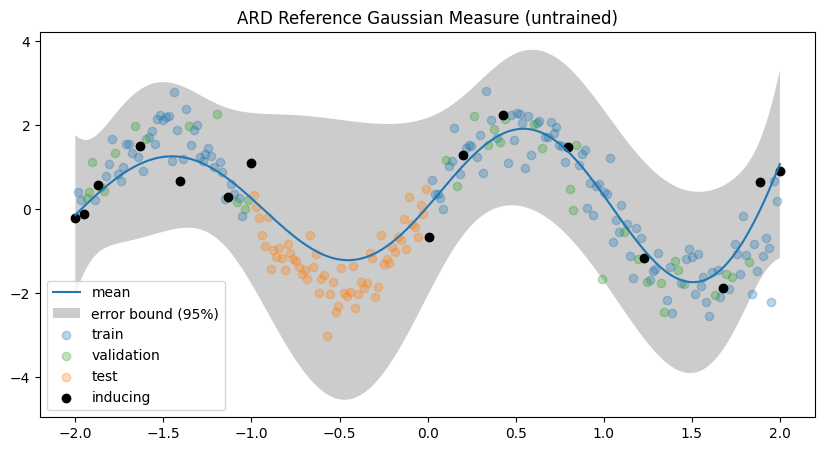

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("ARD Reference Gaussian Measure (untrained)")
plt.scatter(x_train, y_train, label="train", alpha=0.3, color="tab:blue")
plt.scatter(
    x_validation, y_validation, label="validation", alpha=0.3, color="tab:green"
)
plt.scatter(x_test, y_test, label="test", alpha=0.3, color="tab:orange")
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()

## NNGP Kernel

In [9]:
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(10, W_std=5, b_std=5),
    stax.Erf(),
    stax.Dense(1, W_std=10, b_std=10),
)

apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnames="get")

In [10]:
nngp_gaussian_measure = ReferenceGaussianMeasure(
    x=x_inducing,
    y=y_inducing,
    kernel=NeuralNetworkGaussianProcessKernel(kernel_fn),
    mean_function=ConstantFunction(),
)
nngp_gaussian_measure_parameters = nngp_gaussian_measure.generate_parameters(
    {
        "log_observation_noise": jnp.log(1e-3),
        "mean_function": {"constant": 0},
        "kernel": {},
    }
)
mean = nngp_gaussian_measure.calculate_mean(
    x=x, parameters=nngp_gaussian_measure_parameters
)
covariance = nngp_gaussian_measure.calculate_covariance(
    x=x, parameters=nngp_gaussian_measure_parameters
)

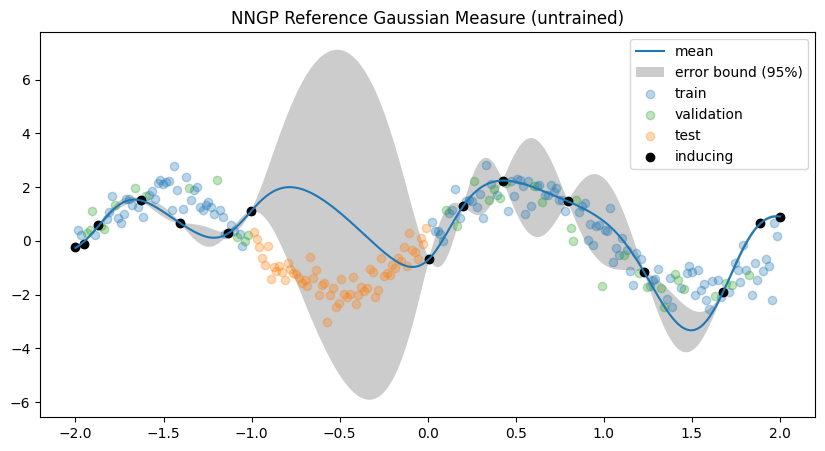

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("NNGP Reference Gaussian Measure (untrained)")
plt.scatter(x_train, y_train, label="train", alpha=0.3, color="tab:blue")
plt.scatter(
    x_validation, y_validation, label="validation", alpha=0.3, color="tab:green"
)
plt.scatter(x_test, y_test, label="test", alpha=0.3, color="tab:orange")
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()

# Approximate Measures

## SVGP

### ARD Kernel

In [12]:
ard_svgp_approximate_gaussian_measure = ApproximateGaussianMeasure(
    x=x_train,
    y=y_train,
    kernel=StochasticVariationalGaussianProcessKernel(
        reference_kernel_parameters=ard_gaussian_measure_parameters.kernel,
        log_observation_noise=ard_gaussian_measure_parameters.log_observation_noise,
        reference_kernel=ard_gaussian_measure.kernel,
        inducing_points=ard_gaussian_measure.x,
        training_points=x_train,
    ),
    mean_function=StochasticVariationalGaussianProcessMeanFunction(
        reference_mean_function_parameters=ard_gaussian_measure_parameters.mean_function,
        reference_mean_function=ard_gaussian_measure.mean_function,
        reference_kernel_function_parameters=ard_gaussian_measure_parameters.kernel,
        reference_kernel=ard_gaussian_measure.kernel,
        inducing_points=ard_gaussian_measure.x,
    ),
    reference_gaussian_measure=ard_gaussian_measure,
    reference_gaussian_measure_parameters=ard_gaussian_measure_parameters,
)

In [13]:
key, subkey = random.split(key)
ard_svgp_approximate_gaussian_measure_parameters = ard_svgp_approximate_gaussian_measure.generate_parameters(
    {
        "mean_function": ard_svgp_approximate_gaussian_measure.mean_function.initialise_random_parameters(
            key
        ),
        "kernel": {},
    }
)
mean = ard_svgp_approximate_gaussian_measure.calculate_mean(
    x=x, parameters=ard_svgp_approximate_gaussian_measure_parameters
)
covariance = ard_svgp_approximate_gaussian_measure.calculate_covariance(
    x=x, parameters=ard_svgp_approximate_gaussian_measure_parameters
)

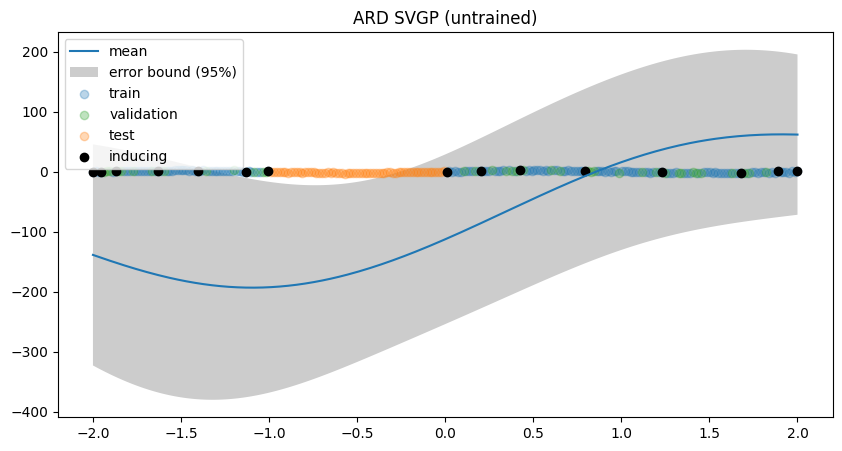

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("ARD SVGP (untrained)")
plt.scatter(x_train, y_train, label="train", alpha=0.3, color="tab:blue")
plt.scatter(
    x_validation, y_validation, label="validation", alpha=0.3, color="tab:green"
)
plt.scatter(x_test, y_test, label="test", alpha=0.3, color="tab:orange")
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()

### NNGP Kernel

In [15]:
nngp_svgp_approximate_gaussian_measure = ApproximateGaussianMeasure(
    x=x_train,
    y=y_train,
    kernel=StochasticVariationalGaussianProcessKernel(
        reference_kernel_parameters=nngp_gaussian_measure_parameters.kernel,
        log_observation_noise=nngp_gaussian_measure_parameters.log_observation_noise,
        reference_kernel=nngp_gaussian_measure.kernel,
        inducing_points=nngp_gaussian_measure.x,
        training_points=x_train,
    ),
    mean_function=StochasticVariationalGaussianProcessMeanFunction(
        reference_mean_function_parameters=nngp_gaussian_measure_parameters.mean_function,
        reference_mean_function=nngp_gaussian_measure.mean_function,
        reference_kernel_function_parameters=nngp_gaussian_measure_parameters.kernel,
        reference_kernel=nngp_gaussian_measure.kernel,
        inducing_points=ard_gaussian_measure.x,
    ),
    reference_gaussian_measure=nngp_gaussian_measure,
    reference_gaussian_measure_parameters=nngp_gaussian_measure_parameters,
)

In [16]:
key, subkey = random.split(key)
nngp_svgp_approximate_gaussian_measure_parameters = nngp_svgp_approximate_gaussian_measure.generate_parameters(
    {
        "mean_function": nngp_svgp_approximate_gaussian_measure.mean_function.initialise_random_parameters(
            subkey
        ),
        "kernel": {},
    }
)
mean = nngp_svgp_approximate_gaussian_measure.calculate_mean(
    x=x, parameters=nngp_svgp_approximate_gaussian_measure_parameters
)
covariance = nngp_svgp_approximate_gaussian_measure.calculate_covariance(
    x=x, parameters=nngp_svgp_approximate_gaussian_measure_parameters
)

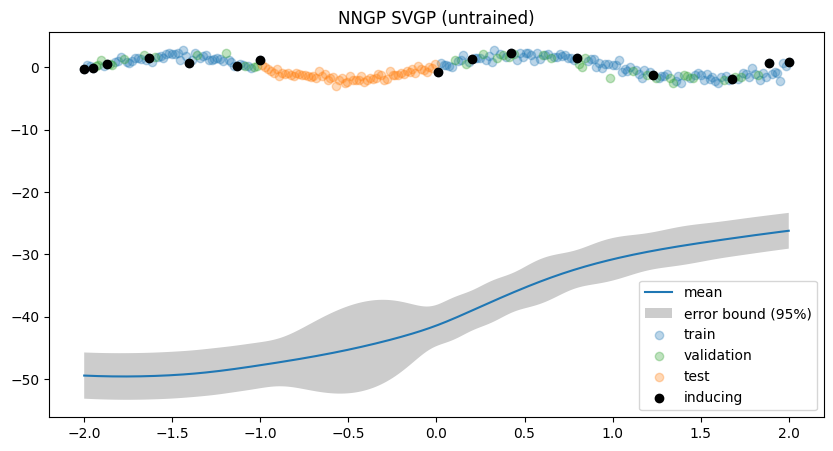

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("NNGP SVGP (untrained)")
plt.scatter(x_train, y_train, label="train", alpha=0.3, color="tab:blue")
plt.scatter(
    x_validation, y_validation, label="validation", alpha=0.3, color="tab:green"
)
plt.scatter(x_test, y_test, label="test", alpha=0.3, color="tab:orange")
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()

## DNN SVGP

In [18]:
class MultiLayerPerceptron(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.tanh(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x.reshape(
            -1,
        )

In [19]:
neural_network = MultiLayerPerceptron([1, 10, 1])
key, subkey = random.split(key)
neural_network_parameters = neural_network.init(subkey, x_train)

### ARD Kernel

In [20]:
ard_dnn_approximate_gaussian_measure = ApproximateGaussianMeasure(
    x=x_train,
    y=y_train,
    kernel=StochasticVariationalGaussianProcessKernel(
        reference_kernel_parameters=ard_gaussian_measure_parameters.kernel,
        log_observation_noise=ard_gaussian_measure_parameters.log_observation_noise,
        reference_kernel=ard_gaussian_measure.kernel,
        inducing_points=ard_gaussian_measure.x,
        training_points=x_train,
    ),
    mean_function=NeuralNetworkMeanFunction(
        reference_mean_function_parameters=ard_gaussian_measure_parameters.mean_function,
        reference_mean_function=ard_gaussian_measure.mean_function,
        neural_network=neural_network,
    ),
    reference_gaussian_measure=ard_gaussian_measure,
    reference_gaussian_measure_parameters=ard_gaussian_measure_parameters,
)

In [21]:
key, subkey = random.split(key)
ard_dnn_approximate_gaussian_measure_parameters = (
    ard_dnn_approximate_gaussian_measure.generate_parameters(
        {
            "mean_function": {"neural_network": neural_network_parameters},
            "kernel": {},
        }
    )
)
mean = ard_dnn_approximate_gaussian_measure.calculate_mean(
    x=x, parameters=ard_dnn_approximate_gaussian_measure_parameters
)
covariance = ard_dnn_approximate_gaussian_measure.calculate_covariance(
    x=x, parameters=ard_dnn_approximate_gaussian_measure_parameters
)

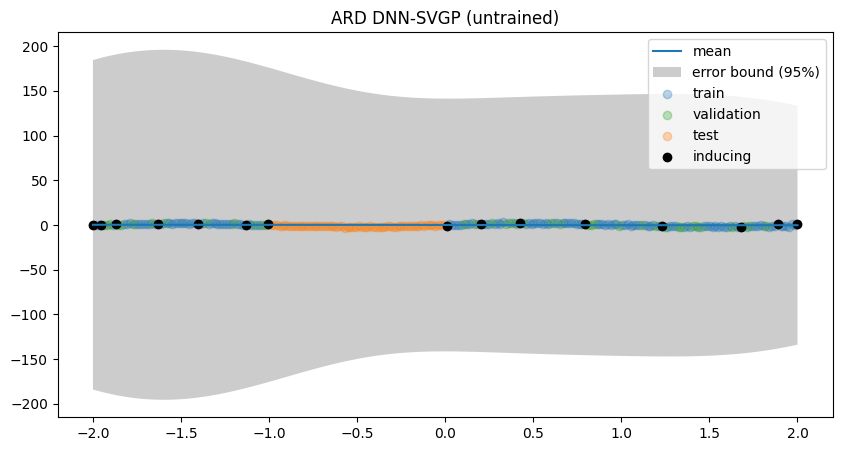

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("ARD DNN-SVGP (untrained)")
plt.scatter(x_train, y_train, label="train", alpha=0.3, color="tab:blue")
plt.scatter(
    x_validation, y_validation, label="validation", alpha=0.3, color="tab:green"
)
plt.scatter(x_test, y_test, label="test", alpha=0.3, color="tab:orange")
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()

### NNGP Kernel 

In [23]:
nngp_dnn_approximate_gaussian_measure = ApproximateGaussianMeasure(
    x=x_train,
    y=y_train,
    kernel=StochasticVariationalGaussianProcessKernel(
        reference_kernel_parameters=nngp_gaussian_measure_parameters.kernel,
        log_observation_noise=nngp_gaussian_measure_parameters.log_observation_noise,
        reference_kernel=nngp_gaussian_measure.kernel,
        inducing_points=nngp_gaussian_measure.x,
        training_points=x_train,
    ),
    mean_function=NeuralNetworkMeanFunction(
        reference_mean_function_parameters=nngp_gaussian_measure_parameters.mean_function,
        reference_mean_function=nngp_gaussian_measure.mean_function,
        neural_network=neural_network,
    ),
    reference_gaussian_measure=nngp_gaussian_measure,
    reference_gaussian_measure_parameters=nngp_gaussian_measure_parameters,
)

In [24]:
key, subkey = random.split(key)
nngp_dnn_approximate_gaussian_measure_parameters = (
    nngp_dnn_approximate_gaussian_measure.generate_parameters(
        {
            "mean_function": {"neural_network": neural_network_parameters},
            "kernel": {},
        }
    )
)
mean = nngp_dnn_approximate_gaussian_measure.calculate_mean(
    x=x, parameters=nngp_dnn_approximate_gaussian_measure_parameters
)
covariance = nngp_dnn_approximate_gaussian_measure.calculate_covariance(
    x=x, parameters=nngp_dnn_approximate_gaussian_measure_parameters
)

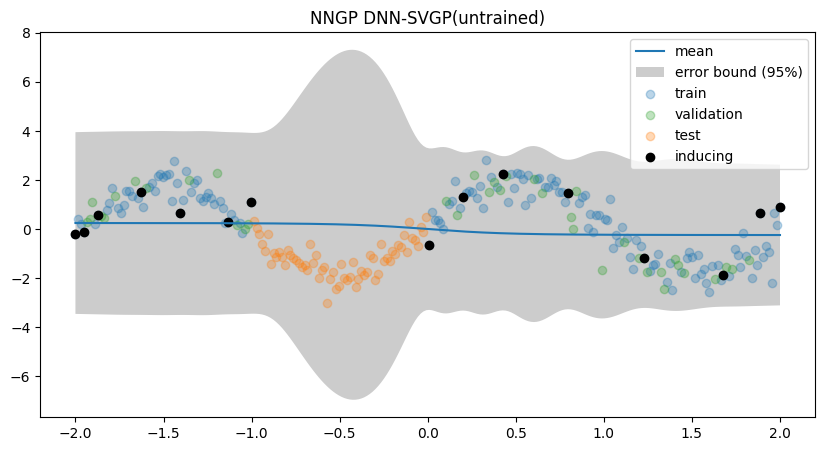

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("NNGP DNN-SVGP(untrained)")
plt.scatter(x_train, y_train, label="train", alpha=0.3, color="tab:blue")
plt.scatter(
    x_validation, y_validation, label="validation", alpha=0.3, color="tab:green"
)
plt.scatter(x_test, y_test, label="test", alpha=0.3, color="tab:orange")
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()

# Gaussian Wasserstein Metric

In [26]:
from src.gaussian_wasserstein_metric import compute_gaussian_wasserstein_metric

In [27]:
def get_batch(key, x_train):
    number_of_batch_points = min(100, int(0.1 * number_of_data_points))
    batch_indices = random.choice(
        key,
        a=jnp.arange(number_of_training_data_points).astype(int),
        shape=(number_of_batch_points,),
        replace=False,
    )
    return x_train[batch_indices]


key, subkey = random.split(key)
x_batch = get_batch(key, x_train)

## ARD Kernels

In [28]:
compute_gaussian_wasserstein_metric(
    p=ard_gaussian_measure,
    q=ard_gaussian_measure,
    p_parameters=ard_gaussian_measure_parameters.dict(),
    q_parameters=ard_gaussian_measure_parameters.dict(),
    x_batch=x_batch,
    x_train=x_train,
    use_symmetric_matrix_eigendecomposition=False
)

/Users/jameswu/repositories/gaussian-wasserstein-inference-in-function-spaces/src/gaussian_wasserstein_metric.py:58: UserWarning: covariance matrices are non-symmetric and cannot utilise GPU resources
  warnings.warn(


Array(0.25469041, dtype=float64)

In [29]:
compute_gaussian_wasserstein_metric(
    p=ard_gaussian_measure,
    q=ard_gaussian_measure,
    p_parameters=ard_gaussian_measure_parameters.dict(),
    q_parameters=ard_gaussian_measure_parameters.dict(),
    x_batch=x_batch,
    x_train=x_batch,
    use_symmetric_matrix_eigendecomposition=True
)

Array(-1.26674582e-09, dtype=float64)

In [30]:
compute_gaussian_wasserstein_metric(
    p=ard_gaussian_measure,
    q=ard_svgp_approximate_gaussian_measure,
    p_parameters=ard_gaussian_measure_parameters.dict(),
    q_parameters=ard_svgp_approximate_gaussian_measure_parameters,
    x_batch=x_batch,
    x_train=x_train,
    use_symmetric_matrix_eigendecomposition=False
)

Array(19382.61251059, dtype=float64)

In [31]:
compute_gaussian_wasserstein_metric(
    p=ard_gaussian_measure,
    q=ard_svgp_approximate_gaussian_measure,
    p_parameters=ard_gaussian_measure_parameters,
    q_parameters=ard_svgp_approximate_gaussian_measure_parameters,
    x_batch=x_batch,
    x_train=x_batch,
    use_symmetric_matrix_eigendecomposition=True
)

Array(18938.56671013, dtype=float64)

In [32]:
# compute_gaussian_wasserstein_metric(
#     p=ard_gaussian_measure,
#     q=ard_gaussian_measure,
#     p_parameters=ard_gaussian_measure_parameters.dict(),
#     q_parameters=ard_gaussian_measure_parameters.dict(),
#     x_batch=x_train,
#     x_train=x_train,
# )

In [33]:
# compute_gaussian_wasserstein_metric(
#     p=ard_gaussian_measure,
#     q=ard_svgp_approximate_gaussian_measure,
#     p_parameters=ard_gaussian_measure_parameters,
#     q_parameters=ard_svgp_approximate_gaussian_measure_parameters,
#     x_batch=x_batch,
#     x_train=x_train,
# )

In [34]:
# compute_gaussian_wasserstein_metric(
#     p=ard_gaussian_measure,
#     q=ard_svgp_approximate_gaussian_measure,
#     p_parameters=ard_gaussian_measure_parameters,
#     q_parameters=ard_svgp_approximate_gaussian_measure_parameters,
#     x_batch=x_train,
#     x_train=x_train,
# )

## NNGP Kernels

In [35]:
# compute_gaussian_wasserstein_metric(
#     p=nngp_gaussian_measure,
#     q=nngp_gaussian_measure,
#     p_parameters=nngp_gaussian_measure_parameters,
#     q_parameters=nngp_gaussian_measure_parameters,
#     x_batch=x_batch,
#     x_train=x_train,
# )

In [36]:
# compute_gaussian_wasserstein_metric(
#     p=nngp_gaussian_measure,
#     q=nngp_gaussian_measure,
#     p_parameters=nngp_gaussian_measure_parameters,
#     q_parameters=nngp_gaussian_measure_parameters,
#     x_batch=x_train,
#     x_train=x_train,
# )

In [37]:
# compute_gaussian_wasserstein_metric(
#     p=nngp_gaussian_measure,
#     q=nngp_dnn_approximate_gaussian_measure,
#     p_parameters=nngp_gaussian_measure_parameters,
#     q_parameters=nngp_dnn_approximate_gaussian_measure_parameters,
#     x_batch=x_batch,
#     x_train=x_train,
# )

In [38]:
# compute_gaussian_wasserstein_metric(
#     p=nngp_gaussian_measure,
#     q=nngp_dnn_approximate_gaussian_measure,
#     p_parameters=nngp_gaussian_measure_parameters,
#     q_parameters=nngp_dnn_approximate_gaussian_measure_parameters,
#     x_batch=x_train,
#     x_train=x_train,
# )

In [39]:
# nngp_dnn_approximate_gaussian_measure.compute_gaussian_wasserstein_metric(
#     parameters=nngp_dnn_approximate_gaussian_measure_parameters,
#     x_batch=x_train,
# )

# Gaussian Wasserstein Inference (non-symmetric)

In [40]:
approximate_gaussian_measure = nngp_dnn_approximate_gaussian_measure
approximate_gaussian_measure.use_symmetric_matrix_eigendecomposition = False
approximate_gaussian_measure_parameters = (
    nngp_dnn_approximate_gaussian_measure_parameters
)

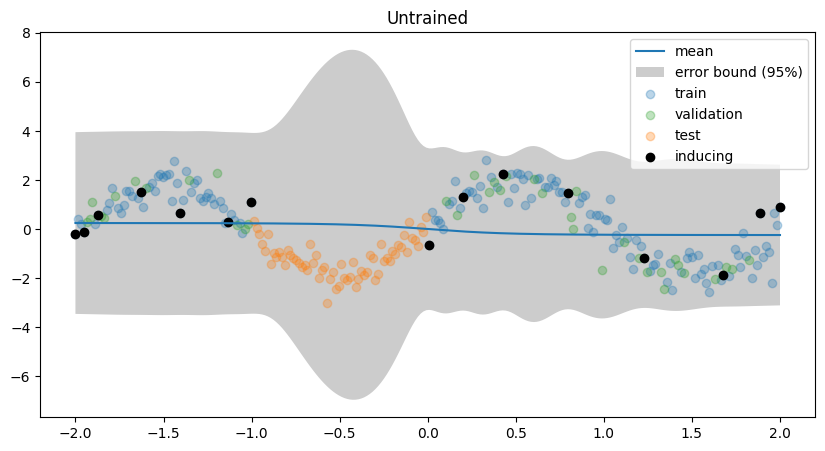

In [41]:
mean = approximate_gaussian_measure.calculate_mean(
    x=x, parameters=nngp_dnn_approximate_gaussian_measure_parameters
)
covariance = approximate_gaussian_measure.calculate_covariance(
    x=x, parameters=nngp_dnn_approximate_gaussian_measure_parameters
)

plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("Untrained")
plt.scatter(x_train, y_train, label="train", alpha=0.3, color="tab:blue")
plt.scatter(
    x_validation, y_validation, label="validation", alpha=0.3, color="tab:green"
)
plt.scatter(x_test, y_test, label="test", alpha=0.3, color="tab:orange")
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()

In [42]:
import optax
import jax
import matplotlib.pyplot as plt

learning_rate = 5e-3
optimizer = optax.adam(learning_rate)
number_of_iterations = 5000
losses = []
opt_state = optimizer.init(approximate_gaussian_measure_parameters.dict())

In [43]:
for i in range(number_of_iterations):
    key, subkey = random.split(key)
    x_batch = get_batch(key, x_train)
    losses.append(
        approximate_gaussian_measure.compute_gaussian_wasserstein_inference_loss(
            parameters=approximate_gaussian_measure_parameters,
            x_batch=x_batch,
        )
    )

    gradients = jax.grad(
        lambda approximate_gaussian_measure_parameters_dict: approximate_gaussian_measure.compute_gaussian_wasserstein_inference_loss(
            parameters=approximate_gaussian_measure_parameters_dict,
            x_batch=x_batch,
        )
    )(approximate_gaussian_measure_parameters.dict())
    updates, opt_state = optimizer.update(gradients, opt_state)
    approximate_gaussian_measure_parameters = (
        approximate_gaussian_measure.generate_parameters(
            optax.apply_updates(approximate_gaussian_measure_parameters.dict(), updates)
        )
    )

/Users/jameswu/repositories/gaussian-wasserstein-inference-in-function-spaces/src/gaussian_wasserstein_metric.py:58: UserWarning: covariance matrices are non-symmetric and cannot utilise GPU resources
  warnings.warn(


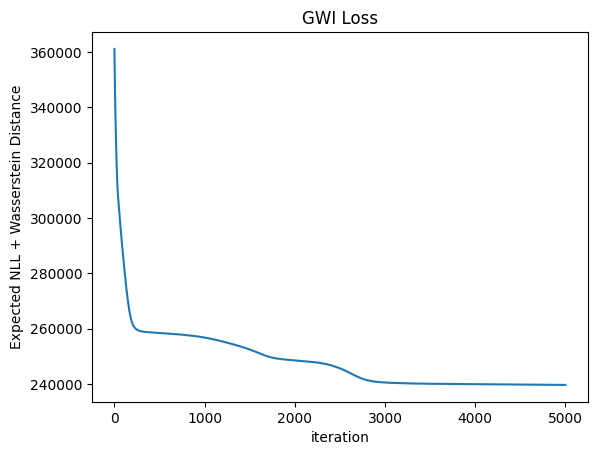

In [44]:
plt.plot(losses)
plt.title("GWI Loss")
plt.xlabel("iteration")
plt.ylabel("Expected NLL + Wasserstein Distance")
plt.show()

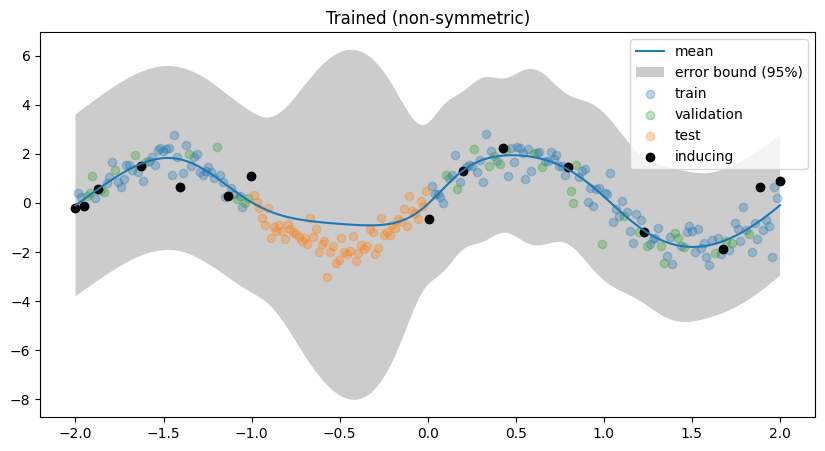

In [45]:
mean = approximate_gaussian_measure.calculate_mean(
    x=x, parameters=approximate_gaussian_measure_parameters
)
covariance = approximate_gaussian_measure.calculate_covariance(
    x=x, parameters=approximate_gaussian_measure_parameters
)
plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("Trained (non-symmetric)")
plt.scatter(x_train, y_train, label="train", alpha=0.3, color="tab:blue")
plt.scatter(
    x_validation, y_validation, label="validation", alpha=0.3, color="tab:green"
)
plt.scatter(x_test, y_test, label="test", alpha=0.3, color="tab:orange")
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()

# Gaussian Wasserstein Inference (symmetric)

In [46]:
approximate_gaussian_measure = nngp_dnn_approximate_gaussian_measure
approximate_gaussian_measure.use_symmetric_matrix_eigendecomposition = True
approximate_gaussian_measure_parameters = (
    nngp_dnn_approximate_gaussian_measure_parameters
)

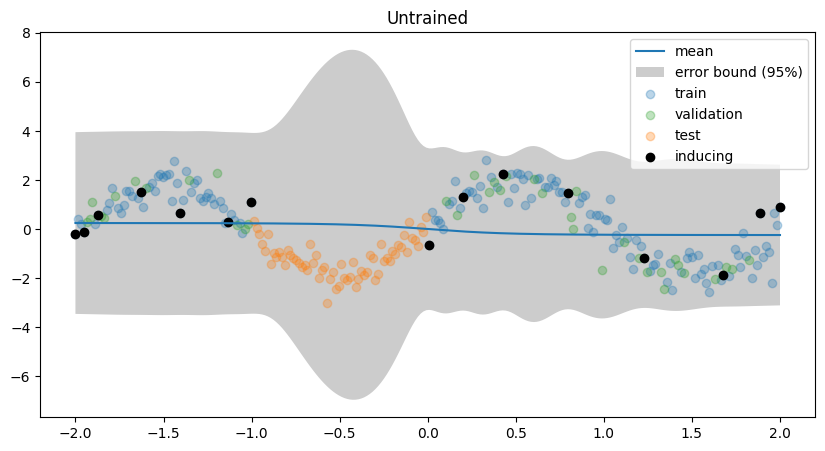

In [47]:
mean = approximate_gaussian_measure.calculate_mean(
    x=x, parameters=nngp_dnn_approximate_gaussian_measure_parameters
)
covariance = approximate_gaussian_measure.calculate_covariance(
    x=x, parameters=nngp_dnn_approximate_gaussian_measure_parameters
)

plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("Untrained")
plt.scatter(x_train, y_train, label="train", alpha=0.3, color="tab:blue")
plt.scatter(
    x_validation, y_validation, label="validation", alpha=0.3, color="tab:green"
)
plt.scatter(x_test, y_test, label="test", alpha=0.3, color="tab:orange")
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()

In [48]:
import optax
import jax
import matplotlib.pyplot as plt

learning_rate = 5e-3
optimizer = optax.adam(learning_rate)
number_of_iterations = 5000
losses = []
opt_state = optimizer.init(approximate_gaussian_measure_parameters.dict())

In [49]:
for i in range(number_of_iterations):
    key, subkey = random.split(key)
    x_batch = get_batch(key, x_train)
    losses.append(
        approximate_gaussian_measure.compute_gaussian_wasserstein_inference_loss(
            parameters=approximate_gaussian_measure_parameters,
            x_batch=x_batch,
        )
    )

    gradients = jax.grad(
        lambda approximate_gaussian_measure_parameters_dict: approximate_gaussian_measure.compute_gaussian_wasserstein_inference_loss(
            parameters=approximate_gaussian_measure_parameters_dict,
            x_batch=x_batch,
        )
    )(approximate_gaussian_measure_parameters.dict())
    updates, opt_state = optimizer.update(gradients, opt_state)
    approximate_gaussian_measure_parameters = (
        approximate_gaussian_measure.generate_parameters(
            optax.apply_updates(approximate_gaussian_measure_parameters.dict(), updates)
        )
    )

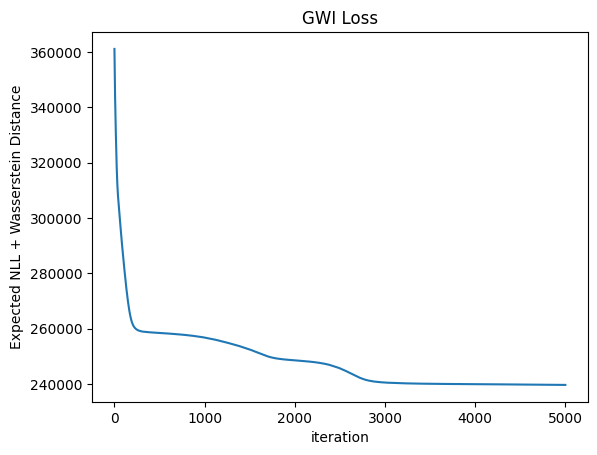

In [50]:
plt.plot(losses)
plt.title("GWI Loss")
plt.xlabel("iteration")
plt.ylabel("Expected NLL + Wasserstein Distance")
plt.show()

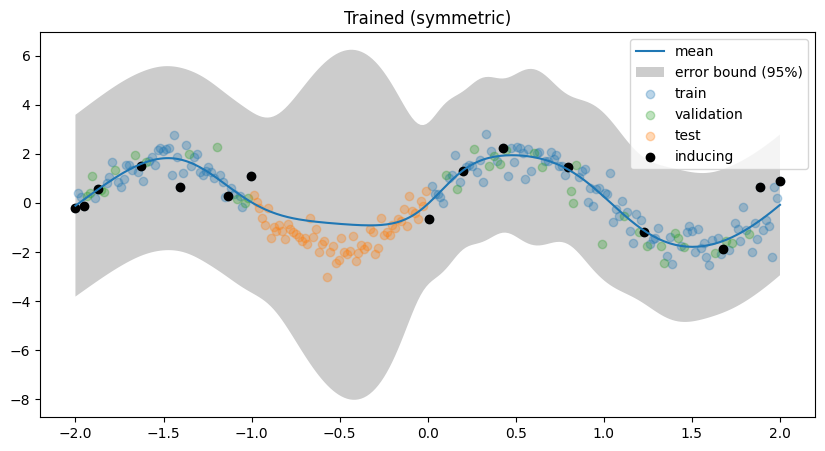

In [51]:
mean = approximate_gaussian_measure.calculate_mean(
    x=x, parameters=approximate_gaussian_measure_parameters
)
covariance = approximate_gaussian_measure.calculate_covariance(
    x=x, parameters=approximate_gaussian_measure_parameters
)
plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("Trained (symmetric)")
plt.scatter(x_train, y_train, label="train", alpha=0.3, color="tab:blue")
plt.scatter(
    x_validation, y_validation, label="validation", alpha=0.3, color="tab:green"
)
plt.scatter(x_test, y_test, label="test", alpha=0.3, color="tab:orange")
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()

# Tempering

In [52]:
from src.gaussian_measures.gaussian_measures import TemperedGaussianMeasure

In [53]:
tempered_gaussian_measure = TemperedGaussianMeasure(
    x=x_validation,
    y=y_validation,
    gaussian_measure=approximate_gaussian_measure,
    gaussian_measure_parameters=approximate_gaussian_measure_parameters,
)
tempered_gaussian_measure_parameters = tempered_gaussian_measure.generate_parameters(
    {"log_tempering_factor": jnp.exp(1.0)}
)

In [54]:
learning_rate = 5e-3
optimizer = optax.adam(learning_rate)
number_of_iterations = 5000
losses = []
opt_state = optimizer.init(tempered_gaussian_measure_parameters.dict())

In [55]:
for i in range(number_of_iterations):
    key, subkey = random.split(key)
    x_batch = get_batch(key, x_train)
    losses.append(
        tempered_gaussian_measure.compute_negative_expected_log_likelihood(
            parameters=tempered_gaussian_measure_parameters,
        )
    )

    gradients = jax.grad(
        lambda tempered_gaussian_measure_parameters_dict: tempered_gaussian_measure.compute_negative_expected_log_likelihood(
            parameters=tempered_gaussian_measure_parameters_dict,
        )
    )(tempered_gaussian_measure_parameters.dict())
    updates, opt_state = optimizer.update(gradients, opt_state)
    tempered_gaussian_measure_parameters = (
        tempered_gaussian_measure.generate_parameters(
            optax.apply_updates(tempered_gaussian_measure_parameters.dict(), updates)
        )
    )

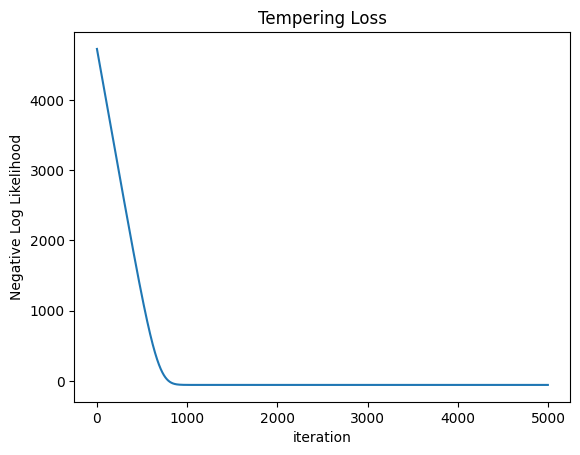

In [56]:
plt.plot(losses)
plt.title("Tempering Loss")
plt.xlabel("iteration")
plt.ylabel("Negative Log Likelihood")
plt.show()

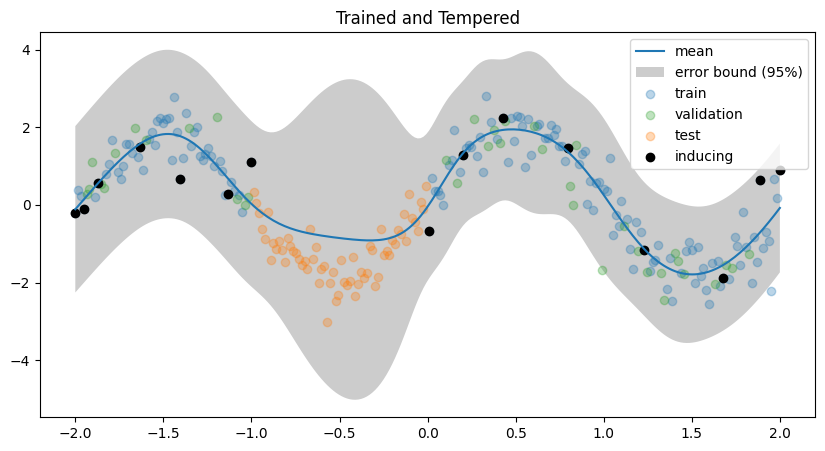

In [57]:
mean = tempered_gaussian_measure.calculate_mean(
    x=x, parameters=tempered_gaussian_measure_parameters
)
covariance = tempered_gaussian_measure.calculate_covariance(
    x=x, parameters=tempered_gaussian_measure_parameters
)
plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("Trained and Tempered")
plt.scatter(x_train, y_train, label="train", alpha=0.3, color="tab:blue")
plt.scatter(
    x_validation, y_validation, label="validation", alpha=0.3, color="tab:green"
)
plt.scatter(x_test, y_test, label="test", alpha=0.3, color="tab:orange")
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()